# DATA EXTRACTION 

In [ ]:
! pip install chembl_webresource_client

In [8]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [9]:
#search for molecule of interest name
target = new_client.target
target_query = target.search('aids')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P05067', 'xref_name': None, 'xre...",Homo sapiens,Beta amyloid A4 protein,5.0,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Mus musculus,Amyloid-beta A4 protein,5.0,False,CHEMBL4523942,"[{'accession': 'P12023', 'component_descriptio...",SINGLE PROTEIN,10090


In [10]:
#choose the Beta amyloid A4 protein	
#save the associated ID code
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL2487'

In [11]:
#extract the specific data
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [12]:
#check if data is correct
df = pd.DataFrame.from_dict(res)
df.head(5)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,357577,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,5.0
1,None,357580,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,2.7
2,None,358965,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,1.8
3,None,368887,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,11.0
4,None,375954,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,10.0


In [13]:
#save data to a csv file
df.to_csv('bioactivity_data_raw.csv', index=False)

# PREPROCESSING

In [14]:
import numpy as np

In [15]:
df2 = df[df.standard_value.notna()]

In [16]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]

#NB: after inspection we see that some IC50 values are negative.
#    with the norm_value() function they will be eliminated by being switching sign

df3['standard_value'] = pd.to_numeric(df3['standard_value'], errors="raise",downcast="integer")
df3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0
...,...,...,...
1267,CHEMBL4558518,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...,1600.0
1268,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,31.0
1269,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,131.0
1270,CHEMBL4534005,COc1cc(-c2cn(C3CCc4ccccc4N(CC(F)(F)F)C3=O)nn2)...,10.0


**calculating pIC50**

In [95]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
      if i < 0:
         i= i*(-1)
      elif i > 100_000_000:
          i = 100_000_000       
      norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [96]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [97]:
df_norm = norm_value(df3)
df4 = pIC50(df_norm)
df4

,molecule_chembl_id,canonical_smiles,pIC50
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5.30
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,5.57
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.74
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,4.96
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,5.00
...,...,...,...
1267,CHEMBL4558518,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...,5.80
1268,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,7.51
1269,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,6.88
1270,CHEMBL4534005,COc1cc(-c2cn(C3CCc4ccccc4N(CC(F)(F)F)C3=O)nn2)...,8.00


In [98]:
#save file 
df4.to_csv("preprocessed_data.csv", index=False)

#reset dataframe o reload data
df = df4.copy() 

# DESCRIPTORS CALCULATION

In [21]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

! unzip padel.zip

In [99]:
selection = ['canonical_smiles','molecule_chembl_id']
df_smi = df[selection]

#convert it in a tab separated file and use the bash program "padel.sh"
df_smi.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! bash padel.sh
#NB: code will require an avarageo of 1 min. per 250 SMILES

In [101]:
#load descriptors file 
df_X = pd.read_csv('descriptors_output.csv')
df_X = df_X.drop(columns='Name')

#load pIC50 column (response variable)
df_Y = df['pIC50']
df_Y

#create the dataset for the analysis
df_final = pd.concat([df_X,df_Y], axis=1)

In [102]:
#save final dataset
df_final.to_csv('final_dataset.csv',index=False)

# ANALYSIS

In [ ]:
! pip install lazypredict

In [104]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split 

In [105]:
# use a feature selection alghoritm to reduce the feature space dimension
# we have a dataset with boolean features so we choose the "VarianceThreshold" algorithm
from sklearn.feature_selection import VarianceThreshold

#NB: we want to remove all features that are either 0 or 1 in more than 80% of the sample 
threshold= 0.8 * (1 - 0.8)

vt = VarianceThreshold(threshold=threshold)    
df_X = vt.fit_transform(df_X)

#check results
df_X.shape

(1142, 170)

In [106]:
# DATA SPLIT
# 80% trining set +  20% test set

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2)

In [ ]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)

models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

In [108]:
# Performance table of the training set (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.91,0.93,0.36,0.08
ExtraTreeRegressor,0.91,0.93,0.36,0.12
ExtraTreesRegressor,0.91,0.93,0.36,2.89
GaussianProcessRegressor,0.91,0.93,0.36,0.77
XGBRegressor,0.91,0.92,0.36,3.81
MLPRegressor,0.88,0.90,0.41,5.32
RandomForestRegressor,0.88,0.90,0.41,3.51
BaggingRegressor,0.86,0.89,0.43,0.19
LGBMRegressor,0.86,0.88,0.44,0.23


In [109]:
# Performance table of the test set (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,


**VISUALIZATION**

[(0.0, 1.0)]

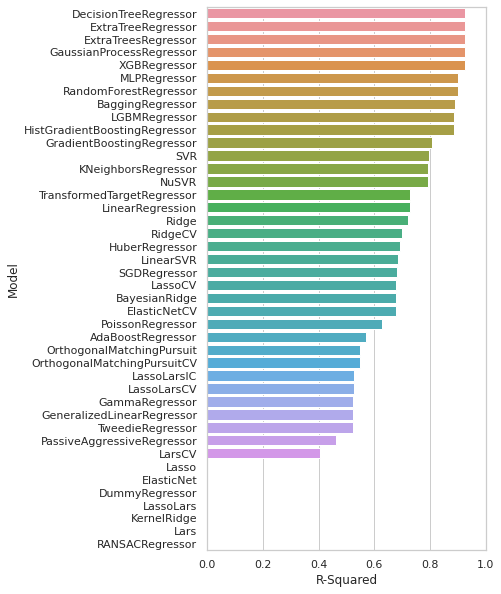

In [110]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

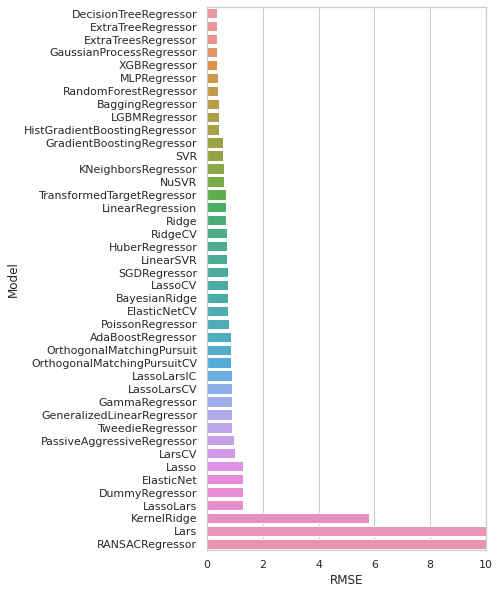

In [111]:
# Bar plot of R-MSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

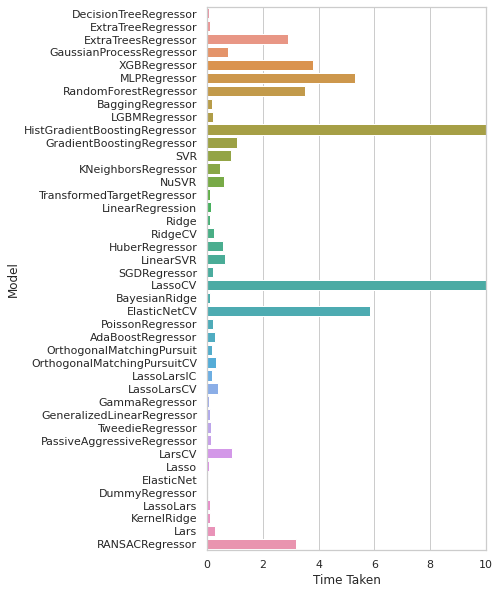

In [112]:
# Bar plot of model calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))